In [3]:
import pandas as pd
import os
from tqdm.notebook import tqdm
import random
import shutil


def split_list(data, split_ratio=0.8):
    # Calculate the index to split the list
    split_index = int(len(data) * split_ratio)
    
    # Shuffle the list randomly
    random.shuffle(data)
    
    # Split the list based on the calculated index
    train_data = data[:split_index]
    test_data = data[split_index:]
    
    return train_data, test_data

def delete_files_in_directory(directory_path):
    # Get the list of files in the directory
    files = os.listdir(directory_path)

    # Iterate through the files and delete each one
    for file_name in tqdm(files):
        file_path = os.path.join(directory_path, file_name)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")
            
    shutil.rmtree(directory_path)

In [4]:
# Example usage:
directory_to_clear = '/kaggle/working/train'
delete_files_in_directory(directory_to_clear)
print('Done')

# Example usage:
directory_to_clear = '/kaggle/working/val'
delete_files_in_directory(directory_to_clear)
print('Done')

0it [00:00, ?it/s]

Done


0it [00:00, ?it/s]

Done


In [5]:


data_path = '/kaggle/input/covid19-detection/Data'

os.mkdir('/kaggle/working/train')
os.mkdir('/kaggle/working/val')

for class_name in os.listdir(data_path):
    if not os.path.isdir(os.path.join(data_path, class_name)):
        continue
    print('Processing: ', class_name)
    images_path = os.path.join(data_path, class_name)
    train_files, val_files = split_list(os.listdir(images_path), 0.8)
    train_ds = f'/kaggle/working/train/{class_name}'
    os.mkdir(train_ds)
    for file_name in tqdm(train_files):
        shutil.copy(os.path.join(images_path, file_name), os.path.join(train_ds, file_name))
    val_ds = f'/kaggle/working/val/{class_name}'
    os.mkdir(val_ds)
    for file_name in tqdm(val_files):
        shutil.copy(os.path.join(images_path, file_name), os.path.join(val_ds, file_name))

Processing:  PNEUMONIA


  0%|          | 0/3412 [00:00<?, ?it/s]

  0%|          | 0/853 [00:00<?, ?it/s]

Processing:  Tuberculosis


  0%|          | 0/2800 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Processing:  Normal


  0%|          | 0/9413 [00:00<?, ?it/s]

  0%|          | 0/2354 [00:00<?, ?it/s]

Processing:  Fibrosis


  0%|          | 0/1348 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

Processing:  COVID


  0%|          | 0/2892 [00:00<?, ?it/s]

  0%|          | 0/724 [00:00<?, ?it/s]

In [6]:
def find_minimum_files_count(directory):
    # Get the list of files in the directory
    files = os.listdir(directory)
    
    # Return the count of files in the directory
    return len(files)

def equalize_folders(file_root):
    # Get a list of all subdirectories in the given root directory
    subdirectories = [d for d in os.listdir(file_root) if os.path.isdir(os.path.join(file_root, d))]
    
    if not subdirectories:
        print("No subdirectories found.")
        return
    
    # Find the minimum number of files among all subdirectories
    min_files_count = min(find_minimum_files_count(os.path.join(file_root, subdir)) for subdir in subdirectories)
    
    # Equalize the number of files in each subdirectory
    for subdir in tqdm(subdirectories):
        subdir_path = os.path.join(file_root, subdir)
        files = os.listdir(subdir_path)
        
        while len(files) > min_files_count:
            # Remove random file
            random_file = os.path.join(subdir_path, random.choice(files))
            os.remove(random_file)
            files.remove(os.path.basename(random_file))
#             print(f"Deleted: {random_file}")

# Example usage:
# root_directory = 'path/to/root'
# equalize_folders(root_directory)


for sub in ['train', 'val']:
    sub_folder = f'/kaggle/working/{sub}'
    equalize_folders(sub_folder)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
input_size = (128,128)
input_shape = (128, 128, 3)
base_dir = '/kaggle/working/'

In [9]:
train_gen = ImageDataGenerator(
    rescale=1./255
)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

In [10]:
train_data = train_gen.flow_from_directory(base_dir + 'train',target_size=input_size,seed=42)
val_data = val_gen.flow_from_directory(base_dir + 'val',target_size=input_size,seed=42)

Found 6740 images belonging to 5 classes.
Found 1690 images belonging to 5 classes.


In [11]:
vgg16 = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
for layer in vgg16.layers:
    layer.trainable = False
vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.95:
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [14]:
callbacks = myCallback()

output = Flatten()(vgg16.output)
output = Dense(500, activation='relu')(output)
output = Dense(100, activation='relu')(output)
output = Dropout(0.5)(output)
output = Dense(5, activation='softmax')(output)
model = Model(inputs=vgg16.input, outputs=output)
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [15]:
history = model.fit(train_data,
                    batch_size=32,
                    epochs=10,
                    validation_data=val_data,
                    callbacks = [callbacks])

Epoch 1/10
211/211 [==============================] - 72s 309ms/step - loss: 0.9661 - accuracy: 0.5991 - val_loss: 0.5616 - val_accuracy: 0.7746
Epoch 2/10
211/211 [==============================] - 62s 294ms/step - loss: 0.6224 - accuracy: 0.7429 - val_loss: 0.4863 - val_accuracy: 0.7905
Epoch 3/10
211/211 [==============================] - 62s 294ms/step - loss: 0.4645 - accuracy: 0.8119 - val_loss: 0.4016 - val_accuracy: 0.8337
Epoch 4/10
211/211 [==============================] - 62s 294ms/step - loss: 0.4206 - accuracy: 0.8309 - val_loss: 0.4504 - val_accuracy: 0.8272
Epoch 5/10
211/211 [==============================] - 62s 293ms/step - loss: 0.3762 - accuracy: 0.8516 - val_loss: 0.3567 - val_accuracy: 0.8633
Epoch 6/10
211/211 [==============================] - 62s 292ms/step - loss: 0.3138 - accuracy: 0.8763 - val_loss: 0.3677 - val_accuracy: 0.8675
Epoch 7/10
211/211 [==============================] - 62s 292ms/step - loss: 0.2743 - accuracy: 0.8935 - val_loss: 0.3749 - val_ac

In [16]:
class_names = train_data.class_indices
class_names

{'COVID': 0, 'Fibrosis': 1, 'Normal': 2, 'PNEUMONIA': 3, 'Tuberculosis': 4}

1/1 [==============================] - 1s 828ms/step
Predicted class: Fibrosis


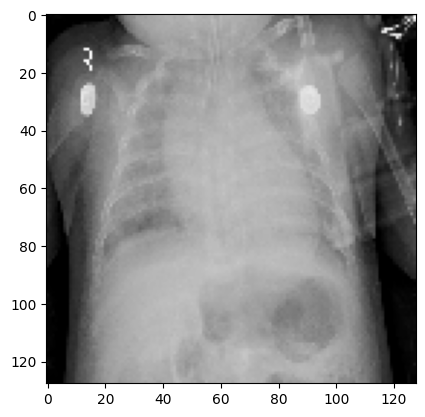

In [17]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt


path = '/kaggle/working/val/PNEUMONIA/person1306_bacteria_3275.jpeg'
img = load_img(path, target_size=(128, 128))
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
predictions = model.predict(images, batch_size=10)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the predicted class label from the 'gen' variable
predicted_class = list(class_names.keys())[list(class_names.values()).index(predicted_class_index)]

# Print the prediction
print("Predicted class:", predicted_class)
# print("Class probabilities:", predictions)

plt.imshow(img)
plt.show()